# CNN による超解像

[Open Images Dataset V4](https://storage.googleapis.com/openimages/web/index.html) からサブセットの 10 万画像を使用して SRCNN を学習し、任意の画像の超解像と PSNR を出力します。

In [1]:
from keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.python.keras import backend as K
import numpy as np

def rescale(image, scale):
  """ 指定された画像のサイズを変更する。 """
  (width, height) = (image.width, image.height)
  (small_width, small_height) = (int(width / scale), int(height / scale))
  return image.resize((small_width, small_height), 3)

def drop_resolution(x, scale):
  """ 指定されたテンソルを画像として縮小/拡大し解像度を劣化させる。 """
  image = array_to_img(x)
  small_image = rescale(image, scale)
  return img_to_array(small_image.resize(image.size, 3))

def data_generator(data_dir, mode, scale=3.0, target_size=(200, 200), batch_size=32, shuffle=True):
  """ DataGenerator の作成。data_dir/mode ディレクトリに保存されている画像を列挙する。 """
  for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode="rgb",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=shuffle
  ):
    x = np.array([drop_resolution(img, scale) for img in imgs])
    yield x / 255., imgs / 255.

def psnr(y_true, y_pred):
  """ PSNR を算出するカスタムメトリクス。パラメータは共に tf.Tensor を取る。
  Custom Metrics 参照: https://keras.io/metrics/#custom-metrics """
  return -10 * K.log(K.mean(K.flatten((y_true - y_pred)) ** 2)) / np.log(10)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.preprocessing.image import ImageDataGenerator
import os

DATA_DIR = "../../../datasets/openimages_v4/"
N_TRAIN_DATA = 1000
N_TEST_DATA = 100
BATCH_SIZE = 32

OUTPUT_FILE = "srcnn_openimages-v4.h5"

train_data_generator = data_generator(DATA_DIR, "challenge2018", batch_size=BATCH_SIZE)
test_x, test_y = next(data_generator(DATA_DIR, "challenge2018", batch_size=N_TEST_DATA, shuffle=False))

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=9, padding="same", activation="relu", input_shape=(None, None, 3)))
model.add(Conv2D(filters=32, kernel_size=1, padding="same", activation="relu"))
model.add(Conv2D(filters=3, kernel_size=5, padding="same"))
model.summary()

if not os.path.isfile(OUTPUT_FILE):
  model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=[psnr]
  )
  model.fit_generator(
    train_data_generator,
    validation_data=(test_x, test_y),
    steps_per_epoch=N_TRAIN_DATA // BATCH_SIZE,
    epochs=50
  )
  # カスタムメトリクスが load_model() で復元できないため重みだけ保存
  model.save_weights(OUTPUT_FILE)
else:
  model.load_weights(OUTPUT_FILE)

Found 99999 images belonging to 1 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
Found 99999 images belonging to 1 classes.
31/31 [==============================] - 29s 921ms/step - loss: 0.0361 - psnr: 15.2920 - val_loss: 0.0189 - val_psnr: 17.2437
Epoch 2/50
31/31 [==============================] - 23s 733ms/step - loss: 0.0153 - psnr: 18.2283 - val_loss: 0.0125 - val_psnr: 19.0362
Epoch 3/50
31/31 [========================

(1, 200, 200, 3) (1, 200, 200, 3)


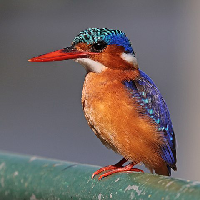

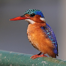

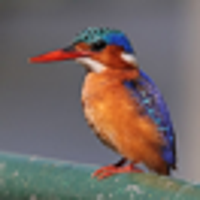

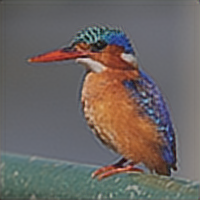

PSNR: 25.991577
(1, 200, 200, 3) (1, 200, 200, 3)


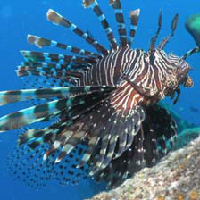

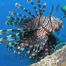

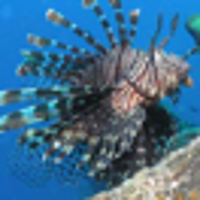

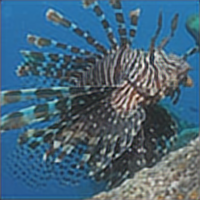

PSNR: 22.745267


In [4]:
from IPython.display import Image, display_png
from keras.preprocessing.image import load_img

files = ["kawasemi.jpg", "lionfish.jpg"]

for file in files:
  image = load_img(file, target_size=(200, 200))
  src = np.array([img_to_array(image) / 255.])

  pred = model.predict(src)
  print(pred.shape, src.shape)

  display_png(image)
  display_png(rescale(image, 3.0))
  display_png(array_to_img(drop_resolution(src[0], 3.0) * 255.))
  display_png(array_to_img(pred[0] * 255.))
  print("PSNR: %f" % (-10 * np.log(np.mean((src - pred).flatten() ** 2)) / np.log(10)))

In [3]:
from keras.layers import Add, Input, Conv2D
from keras.models import Model

def conv_model():
  model = Sequential()
  model.add(Conv2D(filters=64, kernel_size=9, padding="same", activation="relu", input_shape=(None, None, 3)))
  model.add(Conv2D(filters=32, kernel_size=1, padding="same", activation="relu"))
  model.add(Conv2D(filters=3, kernel_size=5, padding="same"))
  return model

def conv_autoencoder_model():
  inputs = Input((None, None, 3), dtype=np.float)
  
  # Encoder
  conv1 = Conv2D(64, 3, padding="same")(inputs)
  conv1 = Conv2D(64, 3, padding="same")(conv1)

  conv2 = Conv2D(64, 3, padding="same", strides=2)(conv1)
  conv2 = Conv2D(64, 3, padding="same")(conv2)

  conv3 = Conv2D(64, 3, padding="same", strides=2)(conv2)
  conv3 = Conv2D(64, 3, padding="same")(conv3)

  # Decoder
  deconv3 = Conv2DTranspose(64, 3, padding="same")(conv3)
  deconv3 = Conv2DTranspose(64, 3, padding="same", stride=2)(deconv3)

  merge2 = Add()([deconv3, conv2])
  deconv2 = Conv2DTranspose(64, 3, padding="same")(merge2)
  deconv2 = Conv2Dtranspose(64, 3, padding="same", strides=2)(deconv2)
  
  merge1 = Add()([deconv2, conv1])
  deconv1 = Conv2DTranspose(64, 3, padding="same")(merge1)
  deconv1 = Conv2DTranspose(3, 3, padding="same")(deconv1)

  output = Add()([deconv1, inputs])

  return Model(inputs, output)